In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib. pyplot as plt
from matplotlib.cm import get_cmap

In [34]:
class Body():
    def __init__(self, x:float, y:float, m:float, vx: float = 0.0, vy: float = 0.0, name: str = "Object") -> None:

        self.x0 = x
        self.y0 = y
        self.vx0 = vx
        self.vy0 = vy
        
        self.init_position:np.ndarray = np.array([x,y])
        self.init_velocity: np.ndarray = np.array([vx, vy])
        self.mass:float = m 
        self.trajectory:list[np.ndarray] = None
        self.time = None

        self.name = name

    def update_pos(self, new_pos_matrix: np.ndarray, timesteps: np.ndarray):
        self.time = timesteps
        self.trajectory = new_pos_matrix

In [50]:
class Simulation():
    def __init__(self, bodies:list[Body], method: str = "RK45", t_max:int=10, t_step = 100, grav_const = 6.67e-11, colors = ["r", "g", "b"], name = "Simulation"):
        self.bodies:list[Body] = bodies
        self.t_max:int = t_max
        self.dt:float = t_step
        self.method:str = method
        self.G = grav_const
        self.colors = colors
        self.name = name

    def run(self):
        t = np.linspace(0, self.t_max, self.dt)
        g = self.G
        m1 = self.bodies[0].mass
        m2 = self.bodies[1].mass
        m3 = self.bodies[2].mass

        def system(t, y):
            #Position of the 3 bodies 
            x1 = y[0:2]
            x2 = y[2:4]
            x3 = y[4:6]
            #Velocities of the 3 bodies
            v1 = y[6:8]
            v2 = y[8:10]
            v3 = y[10:12]

            #Distances of the 3 bodies
            r12 = np.linalg.norm(x2 - x1)
            r13 = np.linalg.norm(x3 - x1)
            r23 = np.linalg.norm(x3 - x2)

            #Accelerations of the 3 bodies
            a1 = g * (m2 * (x2 - x1) / r12**3 + m3 * (x3 - x1) / r13**3)
            a2 = g * (m1 * (x1 - x2) / r12**3 + m3 * (x3 - x2) / r23**3)
            a3 = g * (m1 * (x1 - x3) / r13**3 + m2 * (x2 - x3) / r23**3)

            # print(f"This is a1 {a1}")
            # print(f"This is a2 {a2}")
            # print(f"This is a3 {a3}")

            #Computing the derivatives
            dydt = np.zeros(12)
            dydt[0:2] = v1
            dydt[2:4] = v2
            dydt[4:6] = v3
            dydt[6:8] = a1
            dydt[8:10] = a2
            dydt[10:12] = a3
            
            #print(f"This is dydt {dydt}")
            return dydt
        
        y0 = np.array([self.bodies[0].x0, self.bodies[0].y0, self.bodies[1].x0, self.bodies[1].y0, self.bodies[2].x0, self.bodies[2].y0, self.bodies[0].vx0, self.bodies[0].vy0, self.bodies[1].vx0, self.bodies[1].vy0, self.bodies[2].vx0, self.bodies[2].vy0])
        sol = solve_ivp(fun = system, t_span = [0, self.t_max], y0 = y0, t_eval = t, method = self.method) #dense_output = True)

        self.bodies[0].update_pos(sol.y[0:2, :], sol.t)
        self.bodies[1].update_pos(sol.y[2:4, :], sol.t)
        self.bodies[2].update_pos(sol.y[4:6, :], sol.t)

        return sol
    
    def plot_trajectories(self):
        fig = plt.figure(figsize=(5, 5), dpi = 600)

        #cmap = get_cmap("viridis", len(self.bodies))

        for i, body in enumerate(self.bodies):
            plt.scatter(body.x0, body.y0, alpha = 0.5, marker= "x", color = self.colors[i], label = f"{body.name} initial position")
            plt.plot(body.trajectory[0], body.trajectory[1], alpha = 0.5, linestyle='-', color=self.colors[i])
            plt.scatter(body.trajectory[0][-1], body.trajectory[1][-1], alpha = 0.5 , marker= "o", color = self.colors[i], label = f"{body.name} final position")
        
        #plt.xlabel('x position')
        #plt.ylabel('y position')
        plt.title(f'{self.name} Trajectory')
        plt.grid(True)
        plt.legend()
        plt.show()
            

In [82]:
AU = 1.496e11  # meters
earth_mass = 5.972e24  # kg
sun_mass = 1.989e30  # kg
moon_mass = 7.348e22  # kg
earth_moon_distance = 3.844e8  # meters
earth_orbital_speed = 29780  # meters per second
moon_orbital_speed = 1022  # meters per second

# Initialize bodies
sun = Body(1000, 0, sun_mass, name= "Sun")
earth = Body(AU, 0, earth_mass, vy = earth_orbital_speed, name = "Earth" )
moon = Body(AU + earth_moon_distance, 0, moon_mass, vy = earth_orbital_speed + moon_orbital_speed, name = "Moon")


In [83]:
simulation = Simulation([sun, earth, moon], t_max = 12 * 3.154e7, t_step= 3000, colors = ["yellow", "blue", "grey"], name = "Solar system")

In [84]:
simulation.run()

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.262e+05 ...  3.784e+08  3.785e+08]
        y: [[ 1.000e+03  1.143e+03 ...  3.883e+05  4.058e+05]
            [ 0.000e+00  1.202e+00 ...  3.410e+07  3.411e+07]
            ...
            [ 0.000e+00 -1.078e+03 ... -2.166e+04 -2.221e+04]
            [ 3.080e+04  3.074e+04 ...  2.147e+04  2.090e+04]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1364
     njev: 0
      nlu: 0

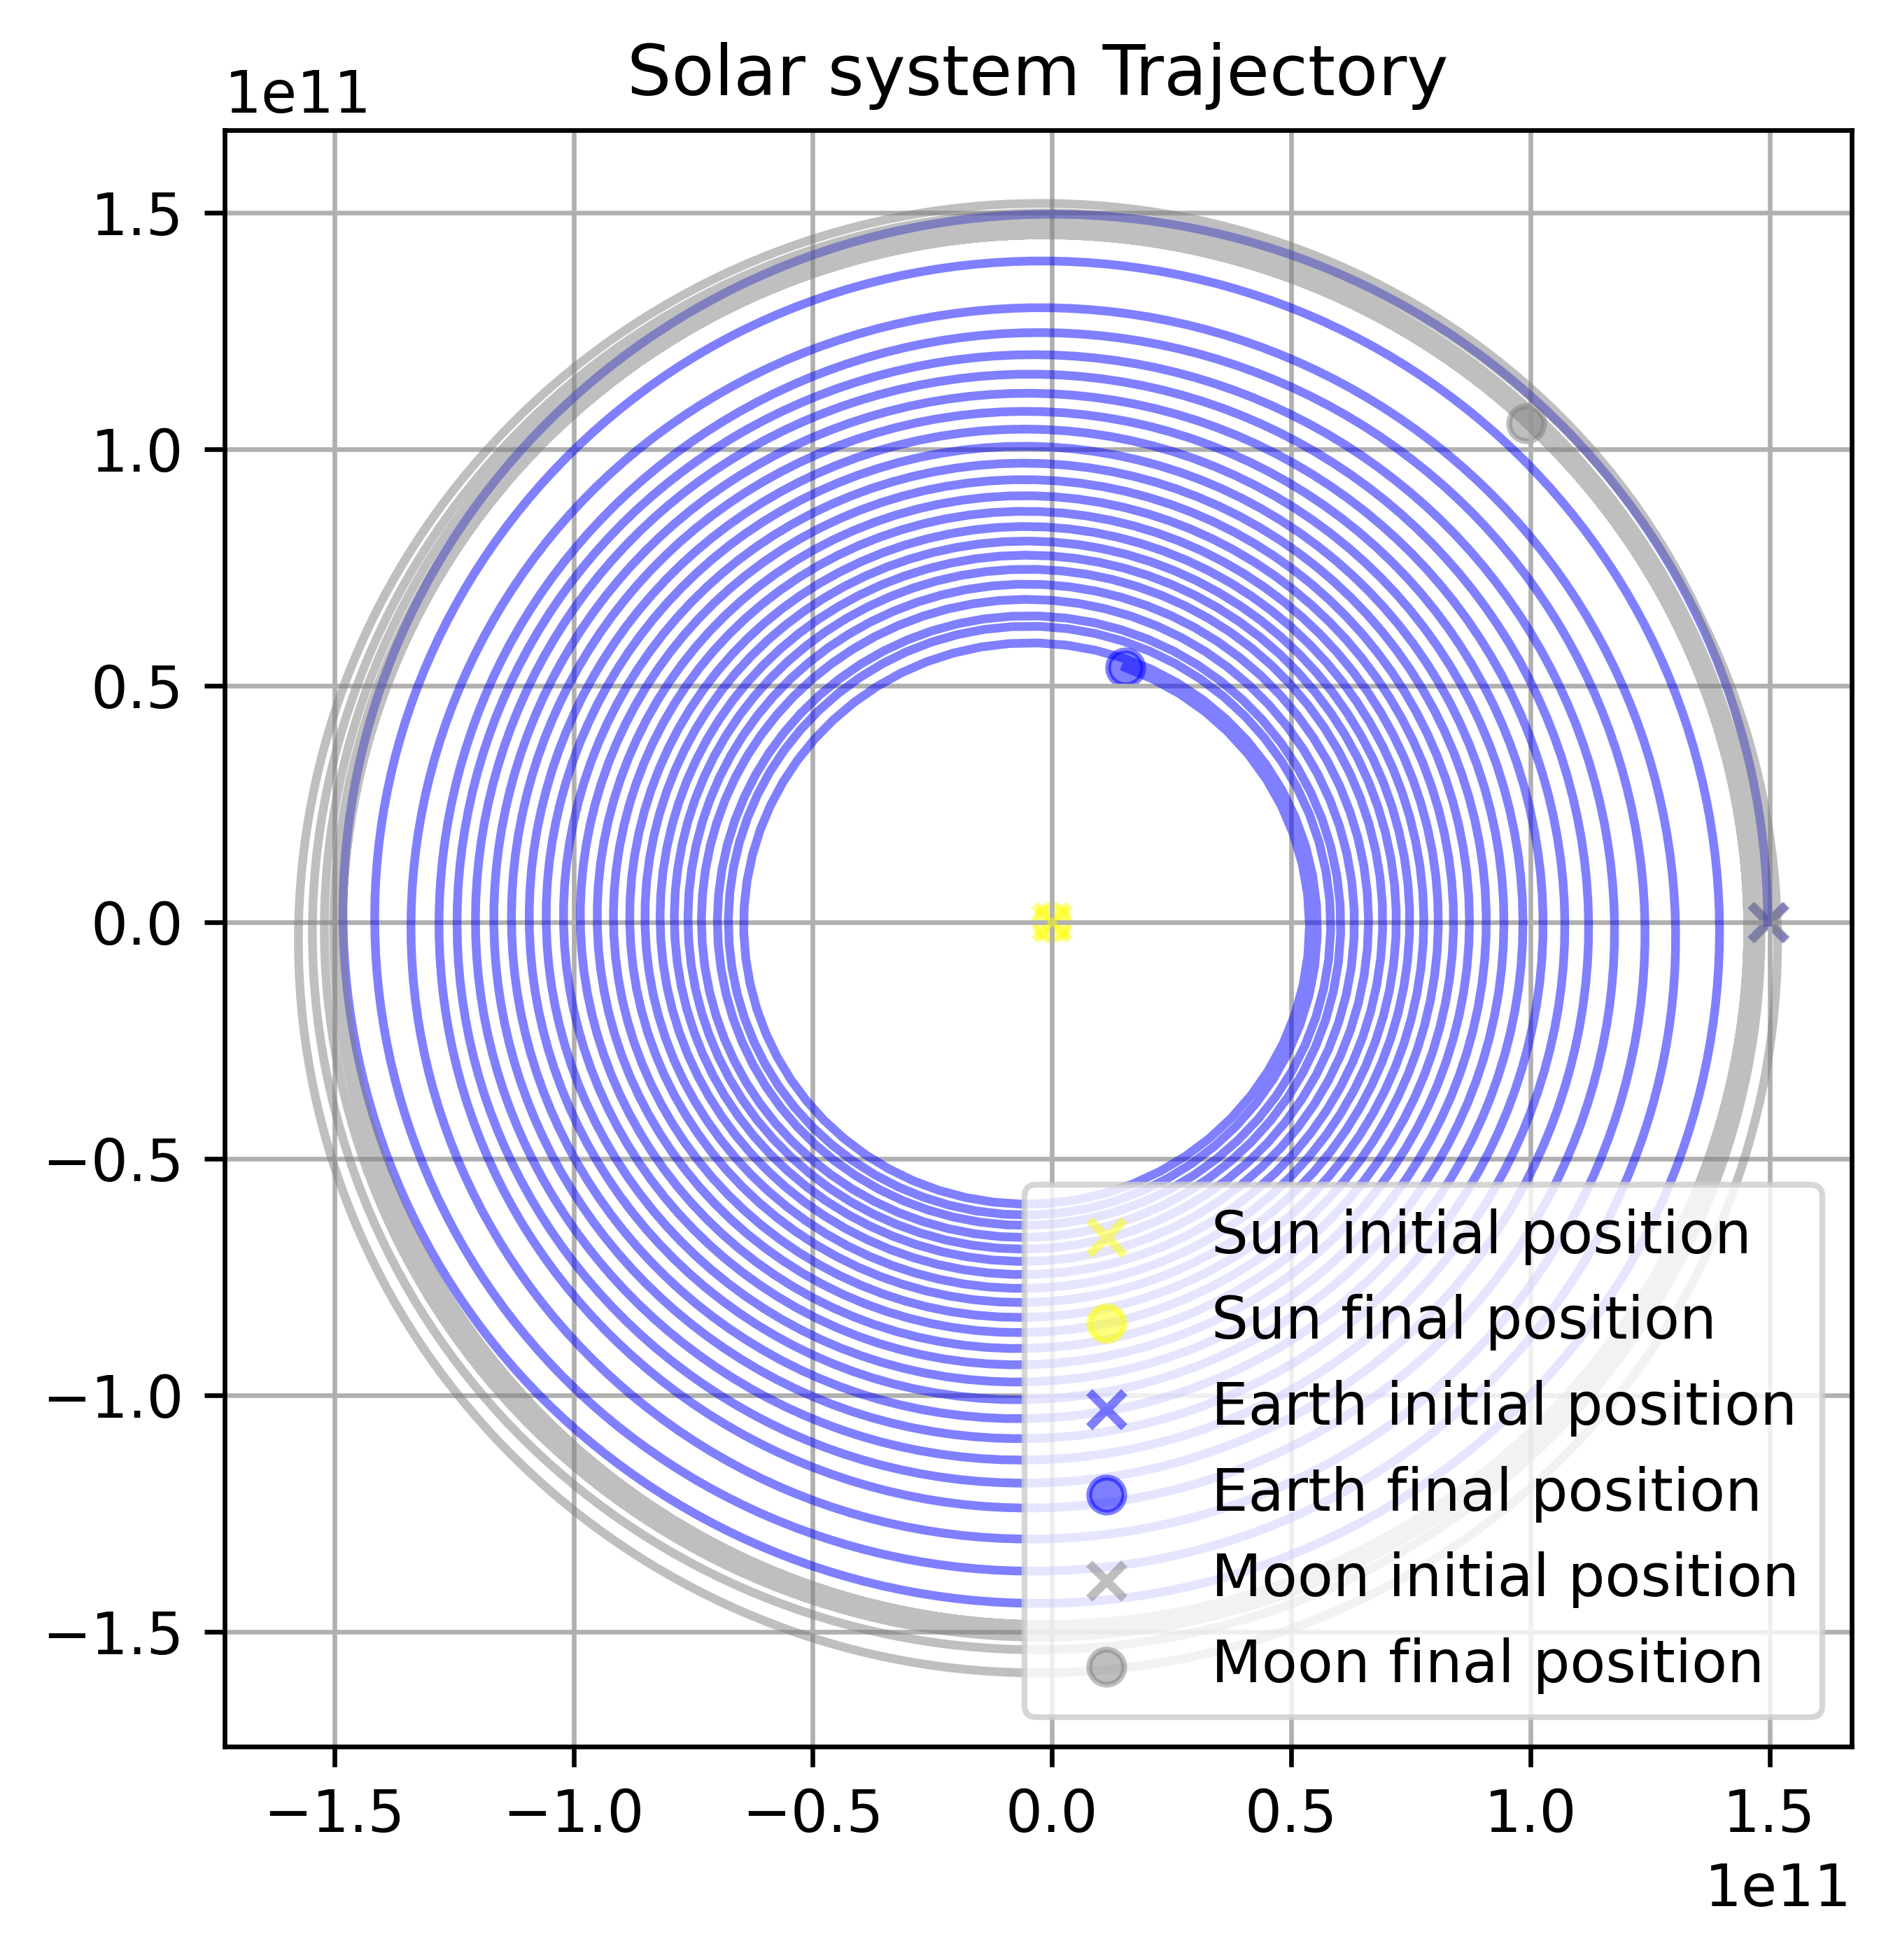

In [85]:
simulation.plot_trajectories()